In [1]:
import os
import json
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

from mllib.model import KerasSurrogate

This notebook allows to visualise the performance of all models in a hyperparameter scan and interactively select the best model.

# Config

In [2]:
scan_dir = f'/data/user/bellotti_r/paper_new/hyperparameter_scans/awa/invertible_model'
config_dir = f'{scan_dir}/configurations'
performance_dir = f'{scan_dir}/performance'
model_dir = f'{scan_dir}/models'

In [3]:
plot_dir = f'{scan_dir}/plots'

if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

save_format = 'jpg'

In [4]:
qois = ['RMS Beamsize in x', 'RMS Beamsize in y', 'Normalized Emittance x', 'Normalized Emittance y', 'Mean Bunch Energy', 'energy spread of the beam', 'Correlation xpx', 'Correlation ypy']
statistics = ['min', '25%', '50%', '75%', 'max']

units = {
    'RMS Beamsize in x': 'mm',
    'RMS Beamsize in y': 'mm',
    'Normalized Emittance x': 'mm rad',
    'Normalized Emittance y': 'mm rad',
    'Mean Bunch Energy': 'MeV',
    'energy spread of the beam': 'keV',
}

In [5]:
best_config = 32

In [6]:
highlight_configs = [best_config]

# Load the info

## Hyperparameter configurations

In [7]:
parameters = pd.read_csv(f'{config_dir}/parameters.csv', index_col=0)
parameters.drop(columns=['loss_weight_x',
                         'loss_weight_y',
                         'loss_weight_z',
                         'coefficient_net_activations'], inplace=True)

for i, row in parameters.iterrows():
    coeff_net_units = json.loads(row['coefficient_net_units'])
    parameters.loc[i, 'depth'] = len(coeff_net_units) - 1
    parameters.loc[i, 'width'] = coeff_net_units[0]

parameters = parameters.drop(columns='coefficient_net_units')
parameters = parameters.astype({'depth': int, 'width': int})

## Model parameters

Iterate over the performance directory, not the model directory. This allows to load only the models that have finished training.

# Load the performance

In [8]:
quantiles = [0.25, 0.5, 0.75, 0.9, 0.95, 0.99]

In [9]:
performance_train = parameters.copy()
performance_val = parameters.copy()

In [10]:
to_skip = [44, 57, 68, 71]

for directory in os.listdir(performance_dir):
    model_ID = int(directory.split('_')[-1])
    if model_ID in to_skip:
        continue

    max_rel_error_train = pd.read_csv(f'{performance_dir}/{directory}/sampling_max_rel_error_train.csv').drop(columns='Unnamed: 0')
    max_rel_error_train_quantiles = max_rel_error_train.quantile(quantiles)['maximum percentage error']
    
    max_rel_error_val = pd.read_csv(f'{performance_dir}/{directory}/sampling_max_rel_error_val.csv').drop(columns='Unnamed: 0')
    max_rel_error_val_quantiles = max_rel_error_val.quantile(quantiles)['maximum percentage error']
    
    for q in quantiles:
        performance_train.loc[model_ID, str(q)] = max_rel_error_train_quantiles.loc[q]
        performance_val.loc[model_ID, str(q)] = max_rel_error_val_quantiles.loc[q]

Load the performance of the baseline model:

In [11]:
performance_train.dropna(inplace=True)
performance_val.dropna(inplace=True)

# Plots

In [12]:
performance_val.sort_values(by='0.75', ascending=True)

number_of_blocks  depth  width       0.25        0.5        0.75  \
32                 8      3    100  35.184047  56.857032   91.607356   
64                12      3    140  35.728470  57.567047   92.685506   
63                12      3    120  37.964997  60.174346   94.539382   
31                 8      3     80  37.649045  58.764559   94.794935   
34                 8      3    140  37.369161  58.764956   95.420193   
..               ...    ...    ...        ...        ...         ...   
55                10      7     60  52.622151  78.226826  158.150943   
41                 8      7     80  54.759162  82.846182  171.883783   
29                 6      7    140  54.361496  80.674745  172.791136   
56                10      7     80  57.946235  84.634694  185.007214   
12                 4      7    100  61.236744  93.278040  229.451254   

           0.9        0.95         0.99  
32  222.169903  417.025001  1407.181421  
64  225.770403  422.635957  1547.716878  
63  219.034215  394.632540  1372.808479  
31  221.835546  392.620272  1271.887146  
34  232.101610  415.860815  1389.956256  
..         ...         ...          ...  
55  370.228124  658.701659  2254.775866  
41  388.418800  655.341977  1941.544473  
29  402.092872  694.066646  2268.760266  
56  408.235796  666.730739  1769.949788  
12  515.274275  840.359912  2237.688978  

[65 rows x 9 columns]

In [13]:
to_plot_train = performance_train.copy()
to_plot_train['color'] = 'blue'
to_plot_train.loc[highlight_configs] = 'red'

## Median maximum percentage errors

In [14]:
fig = go.Figure()

hover_text = []

for ID in performance_train.index:
    text = [f'ID: {ID}']
    param = parameters.loc[ID]
    for i in param.index:
        text.append(f'{i}: {param[i]}')
    text = '<br />'.join(text)
    hover_text.append(text)

fig.add_trace(go.Scatter(
    x=performance_train['0.5'],
    y=performance_val['0.5'],
    mode="markers",
    text=hover_text,
    marker_color=to_plot_train['color']
))

# add the line for perfect generalisation
start_point = (0, 0)
end_point = (max(performance_train['0.5'].max(), performance_val['0.5'].max()),
            max(performance_train['0.5'].max(), performance_val['0.5'].max()))

shapes = [{
    'type': "line",
    'xref': "x",
    'yref': "y",
    'x0': start_point[0],
    'y0': start_point[1],
    'x1': end_point[0],
    'y1': end_point[1],
}]

fig.update_layout(shapes=shapes)
fig.update_layout(annotations=[
    {
        'x': (end_point[0] - start_point[0]) / 2.,
        'y': (end_point[1] - start_point[1]) / 2.,
        'xref': "x",
        'yref': "y",
        'text': "Perfect generalisation",
        'showarrow': True,
        'ax': 10,
        'ay': 50
    }
])
fig.update_layout(title='Median of the maximum percentage error of parameter configs')
fig.update_xaxes(title_text=r'$\tilde{\chi}_{50\%}~\mathrm{(training)}~[\%]$')
fig.update_yaxes(title_text=r'$\tilde{\chi}_{50\%}~\mathrm{(validation)}~[\%]$')

## Upper quartile maximum percentage errors

In [15]:
fig = go.Figure()

hover_text = []

for ID in performance_train.index:
    text = [f'ID: {ID}']
    param = parameters.loc[ID]
    for i in param.index:
        text.append(f'{i}: {param[i]}')
    text = '<br />'.join(text)
    hover_text.append(text)

fig.add_trace(go.Scatter(
    x=performance_train['0.75'],
    y=performance_val['0.75'],
    mode="markers",
    text=hover_text,
    marker_color=to_plot_train['color']
))

# add the line for perfect generalisation
start_point = (0, 0)
end_point = (max(performance_train['0.75'].max(), performance_val['0.75'].max()),
            max(performance_train['0.75'].max(), performance_val['0.75'].max()))

shapes = [{
    'type': "line",
    'xref': "x",
    'yref': "y",
    'x0': start_point[0],
    'y0': start_point[1],
    'x1': end_point[0],
    'y1': end_point[1],
}]

fig.update_layout(shapes=shapes)
fig.update_layout(annotations=[
    {
        'x': (end_point[0] - start_point[0]) / 2.,
        'y': (end_point[1] - start_point[1]) / 2.,
        'xref': "x",
        'yref': "y",
        'text': "Perfect generalisation",
        'showarrow': True,
        'ax': 10,
        'ay': 50
    }
])
fig.update_layout(title='Median of the maximum percentage error of parameter configs')
fig.update_xaxes(title_text=r'$\tilde{\chi}_{75\%}~\mathrm{(training)}~[\%]$')
fig.update_yaxes(title_text=r'$\tilde{\chi}_{75\%}~\mathrm{(validation)}~[\%]$')

In [16]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.scatterplot(x=performance_train['0.75'],
                y=performance_val['0.75'],
                hue=to_plot_train['color'],
                legend=False,
                ax=ax)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim((0., ax.get_xlim()[1]))
ax.set_ylim((0., ax.get_ylim()[1]))
ax.set_xlabel(r'$\tilde{\chi}_{75\%}$ [%] (train)', fontsize=22)
ax.set_ylabel(r'$\tilde{\chi}_{75\%}$ [%] (val)', fontsize=22)
#ax.grid(True)
ax.tick_params(labelsize=12)

# add diagonal line (= line of perfect generalisation)
maximum = max(ax.get_xlim()[1], ax.get_ylim()[1])
ax.plot((0., maximum), (0., maximum), color='black')

# annotate the line of perfect generalisation
annotation_position = (80., 80.)
ax.annotate('Perfect generalisation',
            annotation_position,
            fontsize=15,
            textcoords='offset points',
            xytext=(-40, -80),
            arrowprops={
                'arrowstyle': '-',
            });

# annotate the best model
best_coords = (performance_train.loc[best_config, '0.75'], performance_val.loc[best_config, '0.75'])
ax.annotate(f'Best model\n({best_coords[0]:.3}%, {best_coords[1]:.3}%)',
            best_coords,
            fontsize=15,
            textcoords='offset points',
            xytext=(-150, 20),
            arrowprops={
                'arrowstyle': '->',
                'color': sns.color_palette()[1],
            },
            color=sns.color_palette()[1]);

fig.tight_layout()
fig.savefig(f'{plot_dir}/75_percent.{save_format}', dpi=300)

## 90% percentile maximum percentage errors

In [17]:
fig = go.Figure()

hover_text = []

for ID in performance_train.index:
    text = [f'ID: {ID}']
    param = parameters.loc[ID]
    for i in param.index:
        text.append(f'{i}: {param[i]}')
    text = '<br />'.join(text)
    hover_text.append(text)

fig.add_trace(go.Scatter(
    x=performance_train['0.9'],
    y=performance_val['0.9'],
    mode="markers",
    text=hover_text,
    marker_color=to_plot_train['color']
))

# add the line for perfect generalisation
start_point = (0, 0)
end_point = (max(performance_train['0.9'].max(), performance_val['0.9'].max()),
            max(performance_train['0.9'].max(), performance_val['0.9'].max()))

shapes = [{
    'type': "line",
    'xref': "x",
    'yref': "y",
    'x0': start_point[0],
    'y0': start_point[1],
    'x1': end_point[0],
    'y1': end_point[1],
}]

fig.update_layout(shapes=shapes)
fig.update_layout(annotations=[
    {
        'x': (end_point[0] - start_point[0]) / 2.,
        'y': (end_point[1] - start_point[1]) / 2.,
        'xref': "x",
        'yref': "y",
        'text': "Perfect generalisation",
        'showarrow': True,
        'ax': 10,
        'ay': 50
    }
])
fig.update_layout(title='Median of the maximum percentage error of parameter configs')
fig.update_xaxes(title_text=r'$\tilde{\chi}_{90\%}~\mathrm{(training)}~[\%]$')
fig.update_yaxes(title_text=r'$\tilde{\chi}_{90\%}~\mathrm{(validation)}~[\%]$')

## 95% percentile maximum percentage errors

In [18]:
fig = go.Figure()

hover_text = []

for ID in performance_train.index:
    text = [f'ID: {ID}']
    param = parameters.loc[ID]
    for i in param.index:
        text.append(f'{i}: {param[i]}')
    text = '<br />'.join(text)
    hover_text.append(text)

fig.add_trace(go.Scatter(
    x=performance_train['0.95'],
    y=performance_val['0.95'],
    mode="markers",
    text=hover_text,
    marker_color=to_plot_train['color']
))

# add the line for perfect generalisation
start_point = (0, 0)
end_point = (max(performance_train['0.95'].max(), performance_val['0.95'].max()),
            max(performance_train['0.95'].max(), performance_val['0.95'].max()))

shapes = [{
    'type': "line",
    'xref': "x",
    'yref': "y",
    'x0': start_point[0],
    'y0': start_point[1],
    'x1': end_point[0],
    'y1': end_point[1],
}]

fig.update_layout(shapes=shapes)
fig.update_layout(annotations=[
    {
        'x': (end_point[0] - start_point[0]) / 2.,
        'y': (end_point[1] - start_point[1]) / 2.,
        'xref': "x",
        'yref': "y",
        'text': "Perfect generalisation",
        'showarrow': True,
        'ax': 10,
        'ay': 50
    }
])
fig.update_layout(title='Median of the maximum percentage error of parameter configs')
fig.update_xaxes(title_text=r'$\tilde{\chi}_{95\%}~\mathrm{(training)}~[\%]$')
fig.update_yaxes(title_text=r'$\tilde{\chi}_{95\%}~\mathrm{(validation)}~[\%]$')

## 99% percentile maximum percentage errors

In [19]:
fig = go.Figure()

hover_text = []

for ID in performance_train.index:
    text = [f'ID: {ID}']
    param = parameters.loc[ID]
    for i in param.index:
        text.append(f'{i}: {param[i]}')
    text = '<br />'.join(text)
    hover_text.append(text)

fig.add_trace(go.Scatter(
    x=performance_train['0.99'],
    y=performance_val['0.99'],
    mode="markers",
    text=hover_text,
    marker_color=to_plot_train['color']
))

# add the line for perfect generalisation
start_point = (0, 0)
end_point = (max(performance_train['0.99'].max(), performance_val['0.99'].max()),
            max(performance_train['0.99'].max(), performance_val['0.99'].max()))

shapes = [{
    'type': "line",
    'xref': "x",
    'yref': "y",
    'x0': start_point[0],
    'y0': start_point[1],
    'x1': end_point[0],
    'y1': end_point[1],
}]

fig.update_layout(shapes=shapes)
fig.update_layout(annotations=[
    {
        'x': (end_point[0] - start_point[0]) / 2.,
        'y': (end_point[1] - start_point[1]) / 2.,
        'xref': "x",
        'yref': "y",
        'text': "Perfect generalisation",
        'showarrow': True,
        'ax': 10,
        'ay': 50
    }
])
fig.update_layout(title='Median of the maximum percentage error of parameter configs')
fig.update_xaxes(title_text=r'$\tilde{\chi}_{99\%}~\mathrm{(training)}~[\%]$')
fig.update_yaxes(title_text=r'$\tilde{\chi}_{99\%}~\mathrm{(validation)}~[\%]$')

# Dependence of the parameters

## Parallel coordinates plot

In [20]:
px.parallel_coordinates(performance_val)

## Boxplots for each parameter

In [21]:
performance_val

number_of_blocks  depth  width       0.25        0.5        0.75  \
0                  4      3     60  50.421522  75.556046  143.700465   
1                  4      3     80  44.142160  68.419368  124.426724   
2                  4      3    100  41.878033  63.987403  109.791145   
3                  4      3    120  45.254605  69.991855  129.172195   
4                  4      3    140  45.067624  68.715450  122.193709   
..               ...    ...    ...        ...        ...         ...   
64                12      3    140  35.728470  57.567047   92.685506   
65                12      5     60  41.985230  65.253236  114.510730   
66                12      5     80  41.194239  64.543418  110.753971   
67                12      5    100  39.574765  62.460131  102.950818   
70                12      7     60  49.987114  74.619603  140.647815   

           0.9        0.95         0.99  
0   350.327745  632.202357  2087.026853  
1   300.347900  527.769179  1661.034380  
2   289.133325  530.059252  1684.133292  
3   306.428017  534.480918  1758.308786  
4   297.236643  534.165782  1960.902878  
..         ...         ...          ...  
64  225.770403  422.635957  1547.716878  
65  276.167131  497.913413  1654.008424  
66  265.596377  462.140959  1383.195300  
67  244.590300  449.106364  1526.863472  
70  334.732382  583.564962  1827.978825  

[65 rows x 9 columns]

In [22]:
plot_labels_for_parameters = {
    'number_of_blocks': '$n_b$',
    'depth': '$n_d$',
    'width': '$n_w$',
}

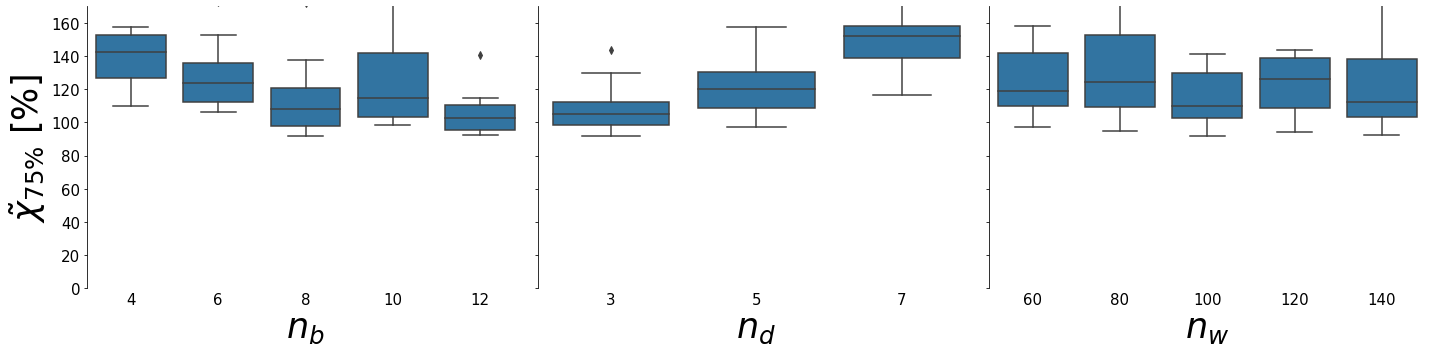

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=True)

for i, param in enumerate(['number_of_blocks', 'depth', 'width']):
    ax = axes[i]

    sns.boxplot(data=performance_val,
                x=param,
                y='0.75',
                color=sns.color_palette()[0],
                ax=ax)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_xlabel(plot_labels_for_parameters[param], fontsize=35)
    ax.set_ylabel('')
    ax.tick_params(axis='x', length=0)
    ax.tick_params(axis='both', labelsize=15)
    ax.set_ylim([0., 170.])

axes[0].set_ylabel(r'$\tilde{\chi}_{75\%}$ [%]', fontsize=35);
#fig.suptitle('Influence of the hyperparameters on accuracy', fontsize=35, fontweight='bold')

#fig.tight_layout(rect=(0, 0, 1, 0.9), h_pad=20)
#fig.subplots_adjust(wspace=0.15)
fig.tight_layout()

fig.savefig(f'{plot_dir}/influence_of_hyperparameters.{save_format}')

In [24]:
parameters[['0.25', '0.5', '0.75', '0.9', '0.95', '0.99']] = performance_val[['0.25', '0.5', '0.75', '0.9', '0.95', '0.99']]

# Save the table of the parameters

In [25]:
parameters_to_save = parameters.copy()
parameters_to_save[['0.25', '0.5', '0.75', '0.9', '0.95', '0.99']] = np.round(parameters_to_save[['0.25', '0.5', '0.75', '0.9', '0.95', '0.99']], decimals=1)

In [26]:
parameters_to_save.to_latex(f'{plot_dir}/parameter_table.tex')

In [27]:
parameters_to_save

number_of_blocks  depth  width  0.25   0.5   0.75    0.9   0.95    0.99
0                  4      3     60  50.4  75.6  143.7  350.3  632.2  2087.0
1                  4      3     80  44.1  68.4  124.4  300.3  527.8  1661.0
2                  4      3    100  41.9  64.0  109.8  289.1  530.1  1684.1
3                  4      3    120  45.3  70.0  129.2  306.4  534.5  1758.3
4                  4      3    140  45.1  68.7  122.2  297.2  534.2  1960.9
..               ...    ...    ...   ...   ...    ...    ...    ...     ...
70                12      7     60  50.0  74.6  140.6  334.7  583.6  1828.0
71                12      7     80   NaN   NaN    NaN    NaN    NaN     NaN
72                12      7    100   NaN   NaN    NaN    NaN    NaN     NaN
73                12      7    120   NaN   NaN    NaN    NaN    NaN     NaN
74                12      7    140   NaN   NaN    NaN    NaN    NaN     NaN

[75 rows x 9 columns]

In [28]:
parameters_to_save.loc[[32, 33, 34, 35, 36, 37, 38, 39, 40]]

number_of_blocks  depth  width  0.25   0.5   0.75    0.9   0.95    0.99
32                 8      3    100  35.2  56.9   91.6  222.2  417.0  1407.2
33                 8      3    120  41.3  64.0  109.8  264.7  477.9  1719.5
34                 8      3    140  37.4  58.8   95.4  232.1  415.9  1390.0
35                 8      5     60  38.3  60.4   97.2  227.8  408.3  1527.8
36                 8      5     80  43.5  67.5  122.0  295.5  520.4  1638.3
37                 8      5    100  41.0  64.6  106.2  259.5  463.9  1487.7
38                 8      5    120  42.1  65.8  111.7  266.2  480.4  1632.5
39                 8      5    140  40.4  63.2  103.4  247.5  449.4  1569.6
40                 8      7     60  43.5  67.0  116.4  274.6  481.8  1538.8

In [29]:
parameters_to_save[parameters_to_save.isna().any(axis=1)]

number_of_blocks  depth  width  0.25  0.5  0.75  0.9  0.95  0.99
44                 8      7    140   NaN  NaN   NaN  NaN   NaN   NaN
57                10      7    100   NaN  NaN   NaN  NaN   NaN   NaN
58                10      7    120   NaN  NaN   NaN  NaN   NaN   NaN
59                10      7    140   NaN  NaN   NaN  NaN   NaN   NaN
68                12      5    120   NaN  NaN   NaN  NaN   NaN   NaN
69                12      5    140   NaN  NaN   NaN  NaN   NaN   NaN
71                12      7     80   NaN  NaN   NaN  NaN   NaN   NaN
72                12      7    100   NaN  NaN   NaN  NaN   NaN   NaN
73                12      7    120   NaN  NaN   NaN  NaN   NaN   NaN
74                12      7    140   NaN  NaN   NaN  NaN   NaN   NaN